In [15]:
import pandas as pd
import numpy as np
import riskfolio as rp
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [16]:
#Read in data and set index as the date
df = pd.read_csv('yf_df.csv')
df.set_index('Date', inplace = True)
df.index = pd.to_datetime(df.index)
df


,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-05-11,8601.795898,185.912842,0.194064,0.002413,3.585065
2020-05-12,8804.477539,189.312500,0.197637,0.002463,3.692374
2020-05-13,9269.987305,199.193283,0.201480,0.002521,3.760424
2020-05-14,9733.721680,202.949097,0.203129,0.002574,3.799387
2020-05-15,9328.197266,195.622665,0.198911,0.002506,3.674653
...,...,...,...,...,...
2024-05-24,68526.101562,3726.934570,0.535753,0.163803,17.247709
2024-05-25,69265.945312,3749.236572,0.541809,0.173960,17.441204
2024-05-26,68518.093750,3825.897461,0.528211,0.166220,17.046471


In [17]:
#Get returns
returns = df.pct_change().dropna() #Overall returns for each asset

In [18]:
#Building portfolio object
port = rp.Portfolio(returns, nea = 4) #Number of Effective Assets (NEA)

port.assets_stats(
    method_mu = 'hist', #Selected method to estimate expected returns based on historical data
    method_cov = 'hist', #Selected method to estimate covariance matrix based on historical data
    d = 0.94)

#Estimate optimal portfolio for mean/cvar ratio
w = port.optimization(
    model = 'Classic', #Either classic, BL(Black Litterman), FM(Factor model), BLFM(Black Litterman w/Factor models)
    rm = 'CVaR', #Risk measure
    obj = 'Sharpe', #Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True, #Use historical scenarios for risk measures
    rf = 0, #Risk free rate
    l = 0) #Risk aversion factor, only useful when obj is 'utility'
w #Optimal weights for our portfolio

,weights
BTC,0.180017
ETH,0.198808
XRP,0.138580
DOGE,0.386927
LINK,0.095668


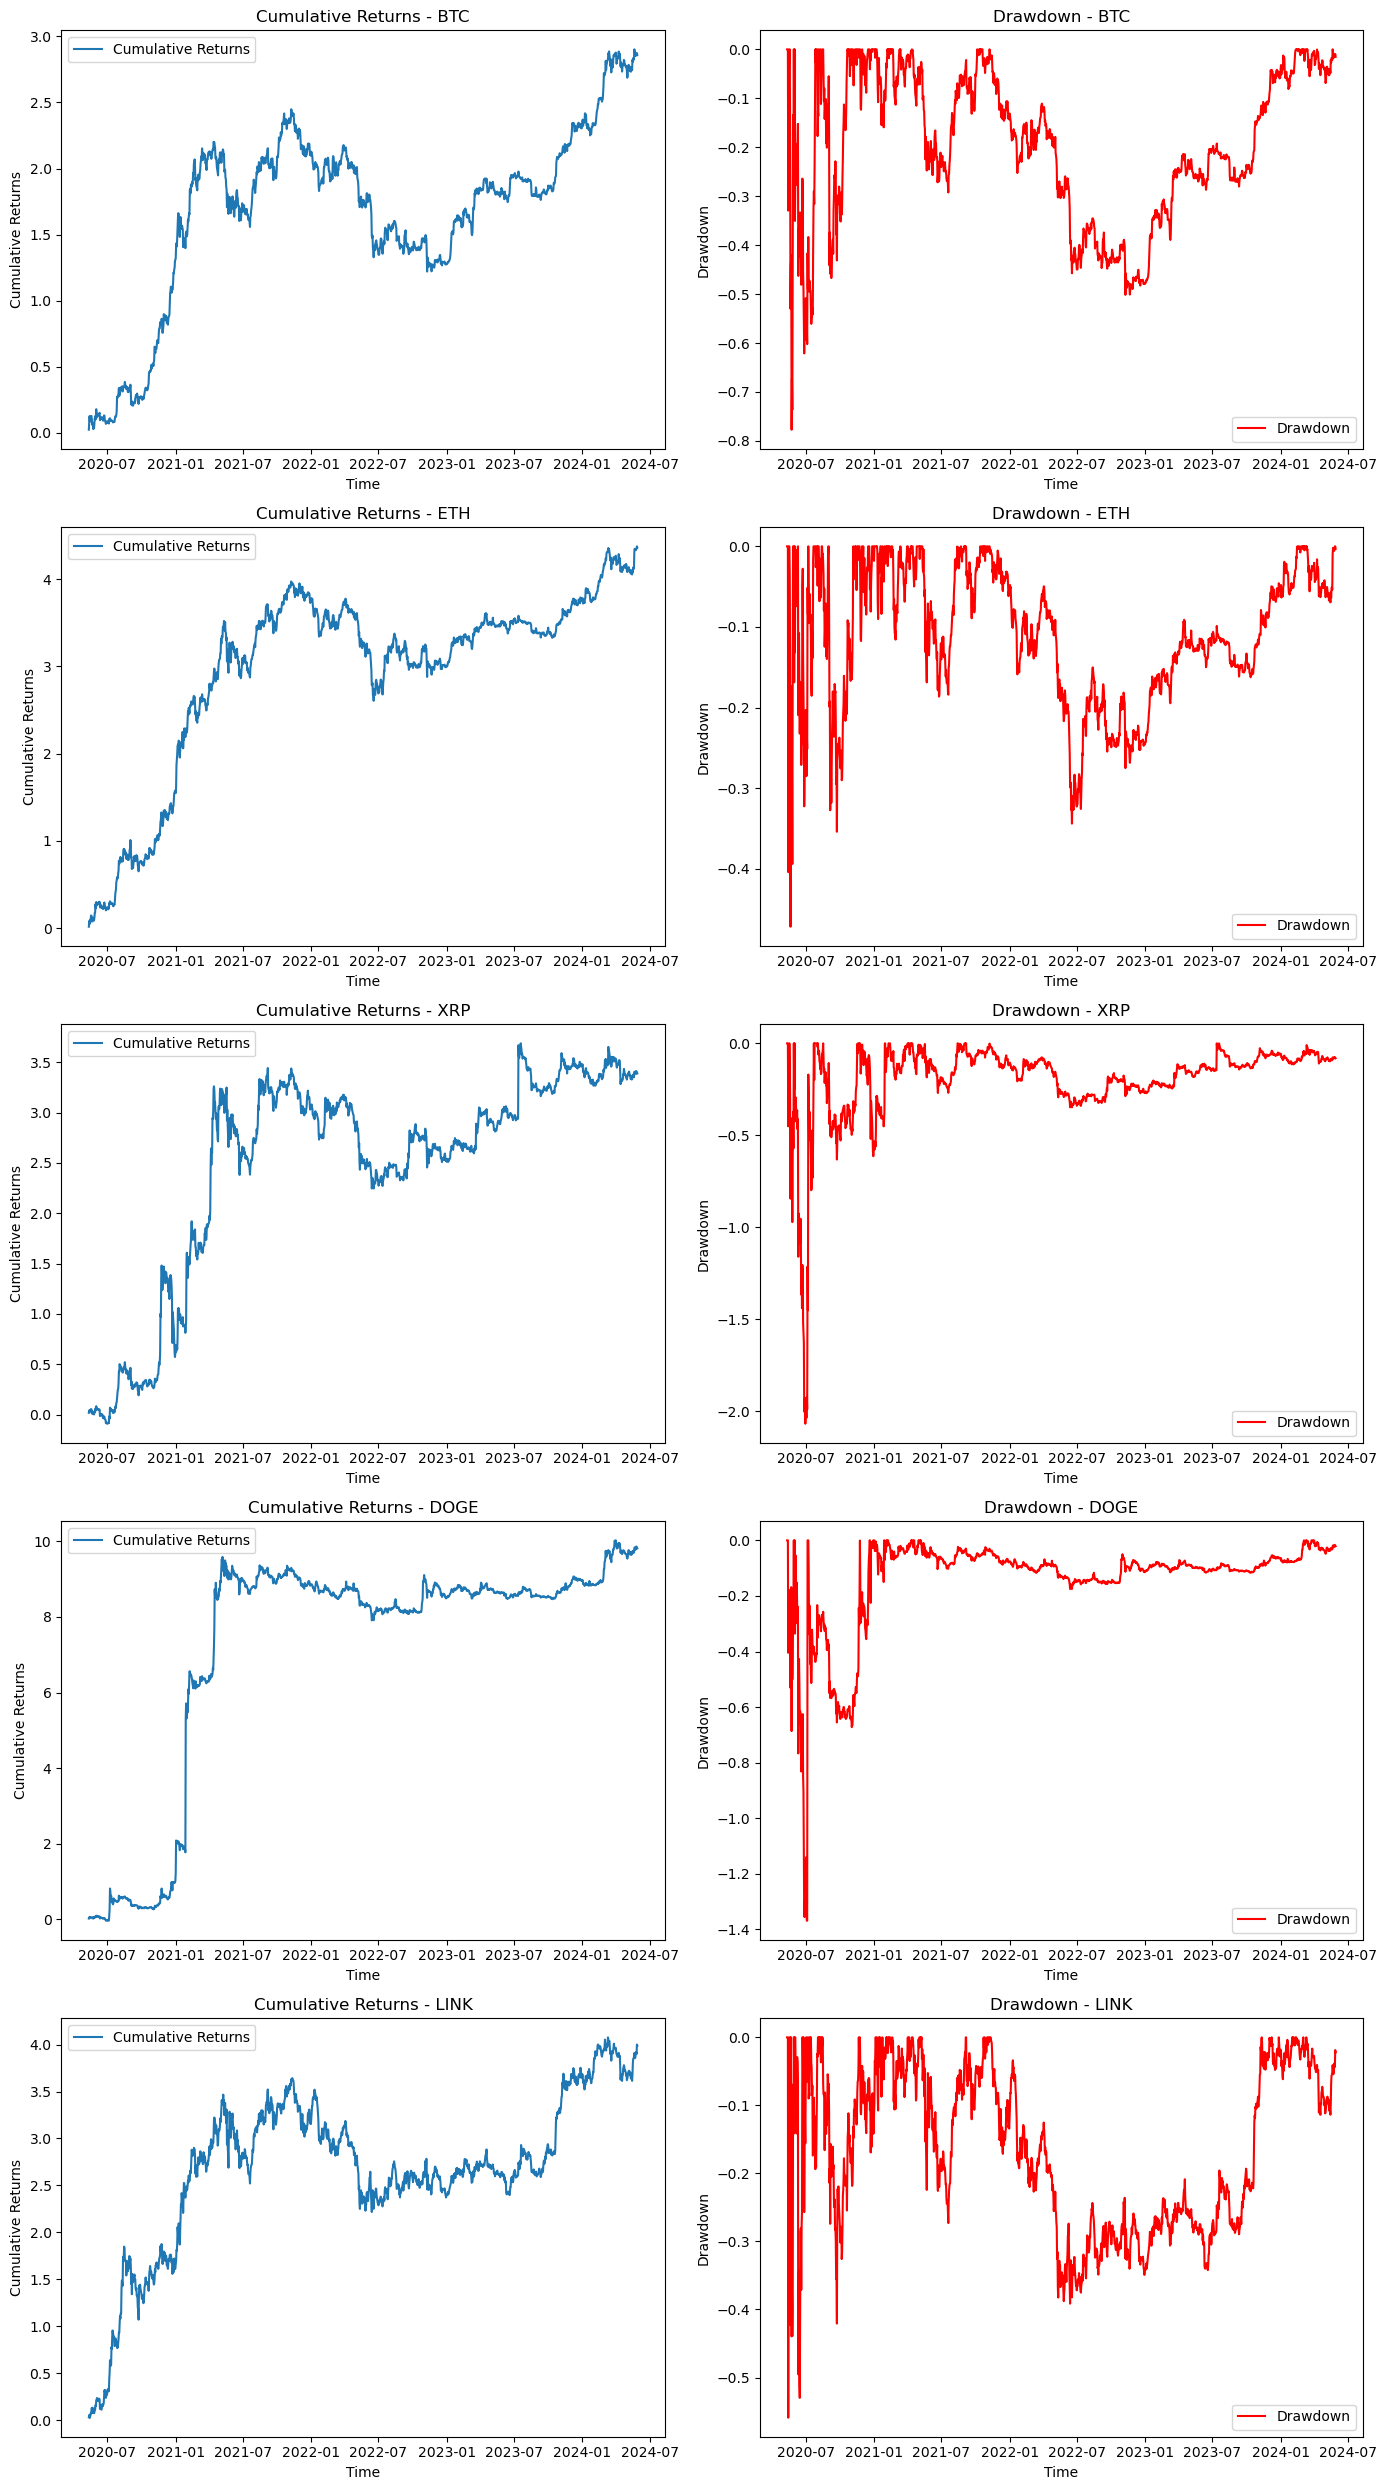

In [19]:
#Checking max draw down using my own formula

def plot_cumulative_returns_and_drawdown(returns):
    # Number of assets
    num_assets = len(returns.columns)  # All columns represent assets

    # Create subplots
    fig, axes = plt.subplots(num_assets, 2, figsize=(14, 5 * num_assets))

    for i, column in enumerate(returns.columns):  # Iterate over each asset
        asset_returns = returns[column]
        
        # Calculate cumulative returns
        cumulative_returns = np.cumsum(asset_returns)
        
        # Calculate peak returns
        peak = np.maximum.accumulate(cumulative_returns)
        
        # Calculate drawdown
        drawdown = (cumulative_returns - peak) / peak
        
        # Plot cumulative returns
        axes[i, 0].plot(cumulative_returns, label='Cumulative Returns')
        axes[i, 0].set_title(f'Cumulative Returns - {column}')
        axes[i, 0].set_xlabel('Time')
        axes[i, 0].set_ylabel('Cumulative Returns')
        axes[i, 0].legend()

        # Plot drawdown
        axes[i, 1].plot(drawdown, label='Drawdown', color='red')
        axes[i, 1].set_title(f'Drawdown - {column}')
        axes[i, 1].set_xlabel('Time')
        axes[i, 1].set_ylabel('Drawdown')
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

plot_cumulative_returns_and_drawdown(returns)

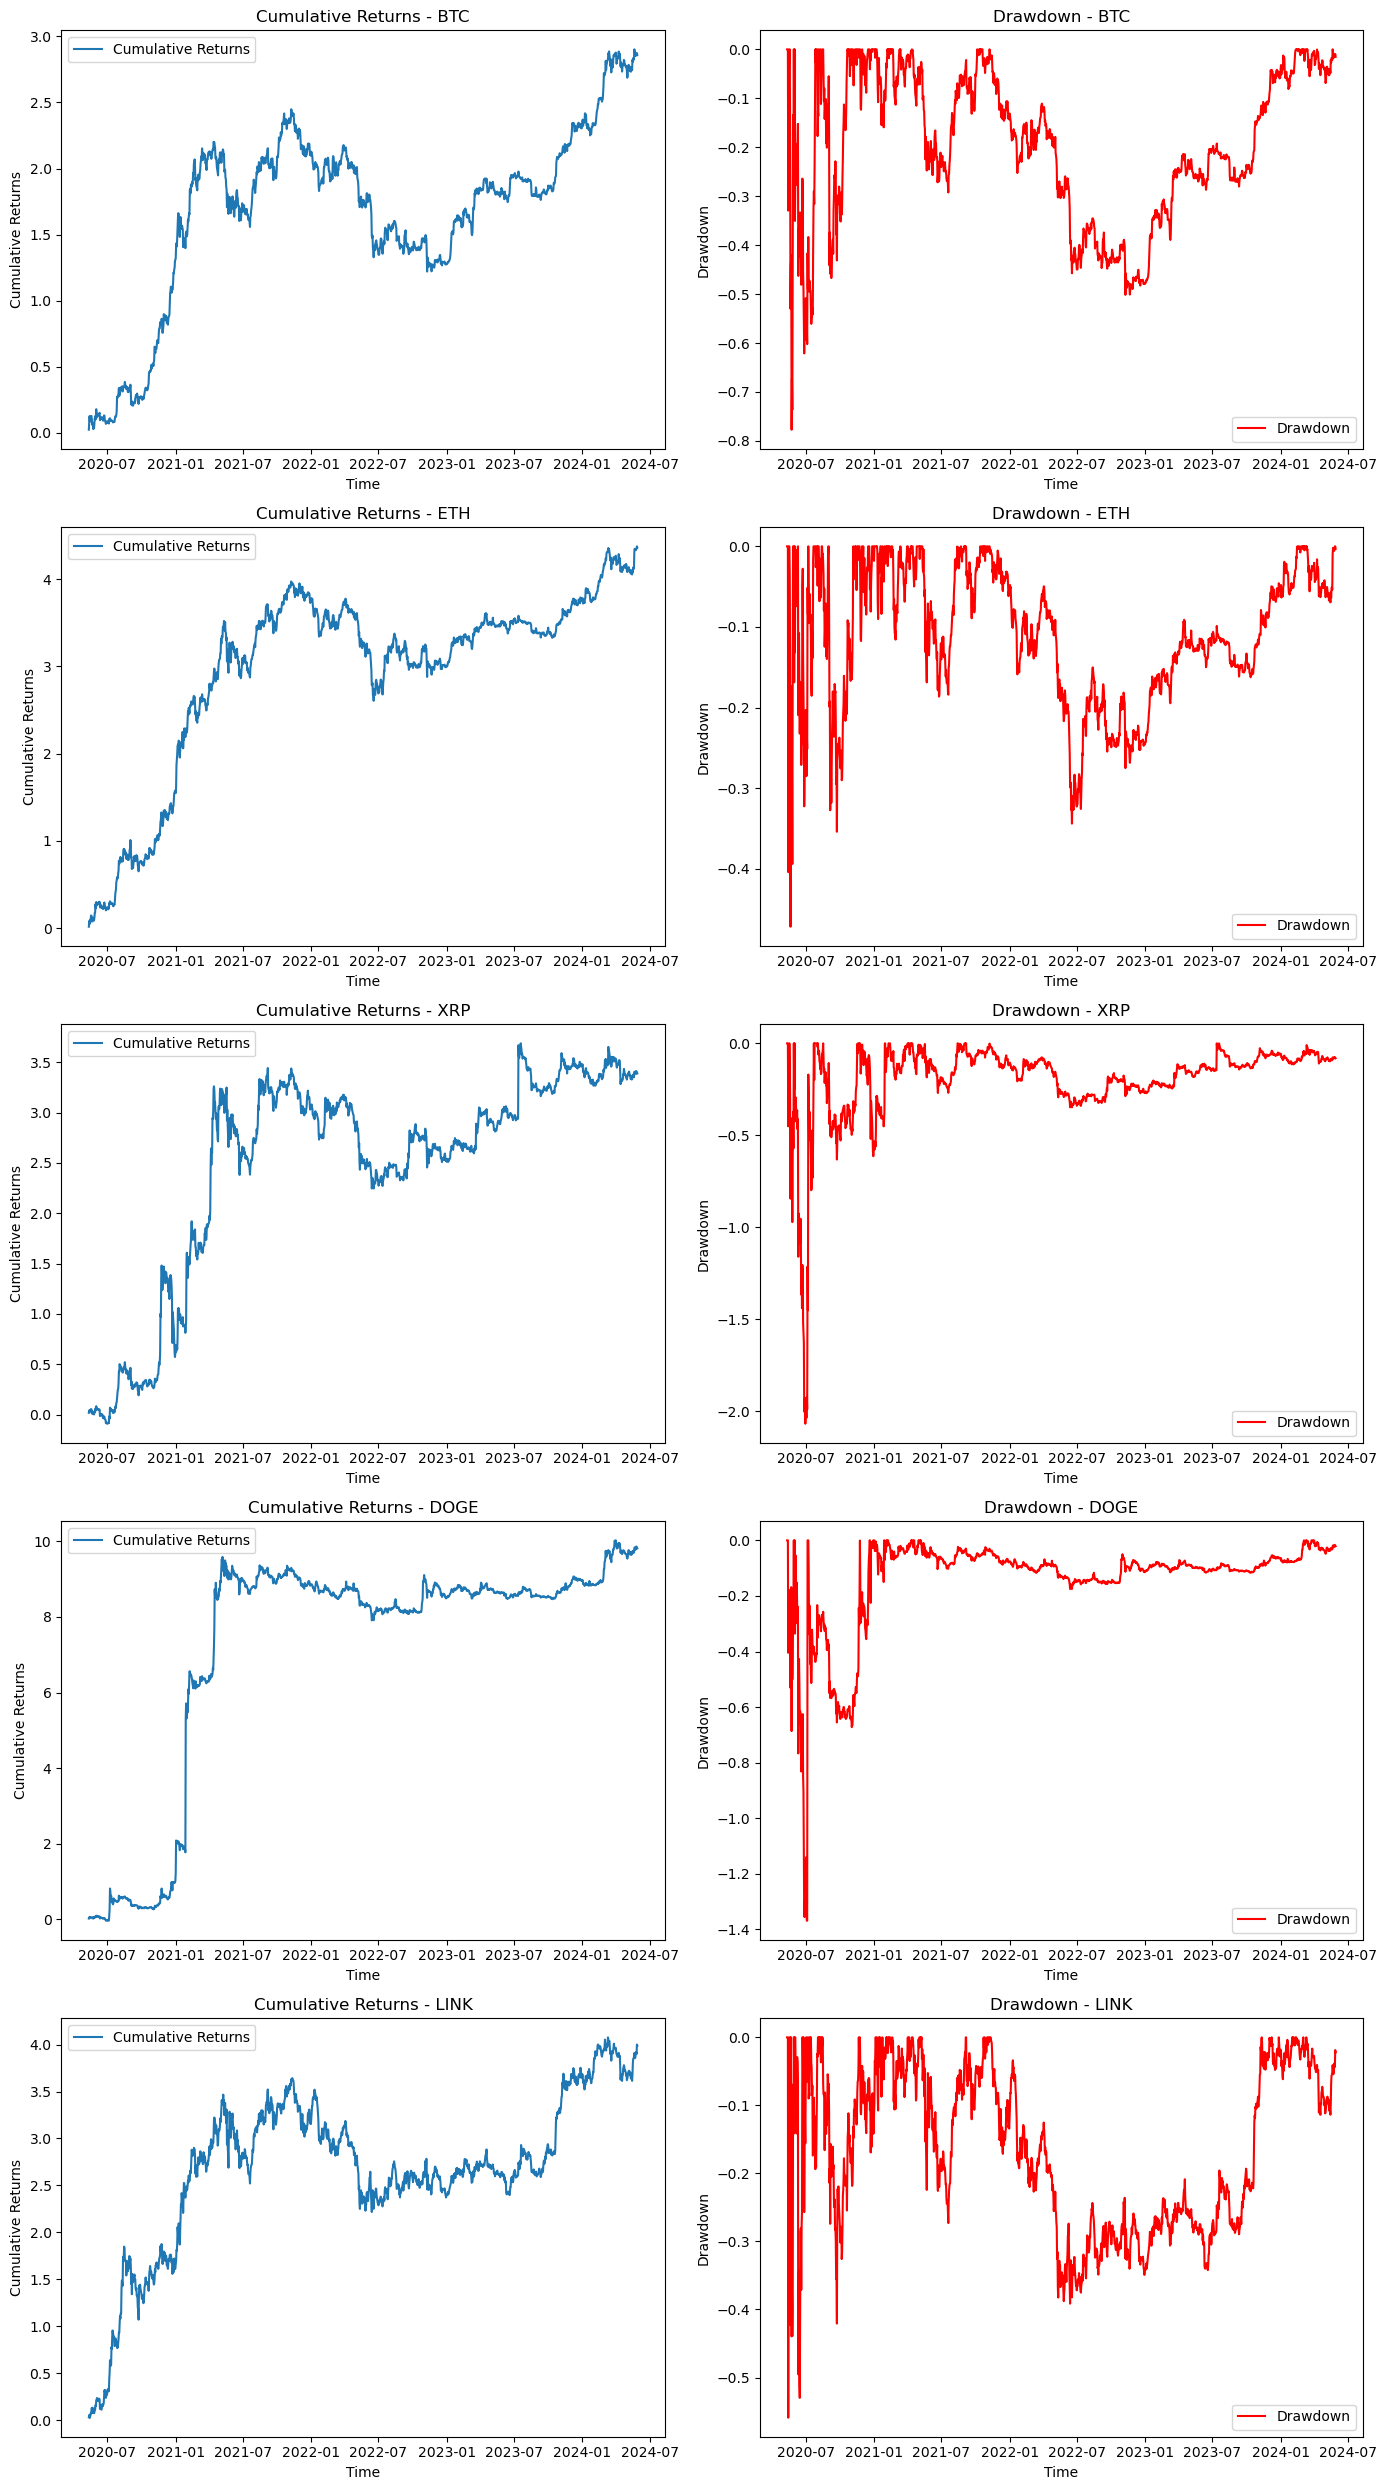

In [20]:
def plot_cumulative_returns_and_drawdown(returns):
    # Number of assets
    num_assets = len(returns.columns)  # All columns represent assets

    # Create subplots
    fig, axes = plt.subplots(num_assets, 2, figsize=(14, 5 * num_assets))

    # Dictionary to store drawdown details
    drawdown_data = {}

    for i, column in enumerate(returns.columns):  # Iterate over each asset
        asset_returns = returns[column]
        
        # Calculate cumulative returns
        cumulative_returns = np.cumsum(asset_returns)
        
        # Calculate peak returns
        peak = np.maximum.accumulate(cumulative_returns)
        
        # Calculate drawdown
        drawdown = (cumulative_returns - peak) / peak
        
        # Store the data in the dictionary
        drawdown_data[column] = {
            'Cumulative Returns': cumulative_returns,
            'Peak': peak,
            'Drawdown': drawdown
        }

        # Plot cumulative returns
        axes[i, 0].plot(cumulative_returns, label='Cumulative Returns')
        axes[i, 0].set_title(f'Cumulative Returns - {column}')
        axes[i, 0].set_xlabel('Time')
        axes[i, 0].set_ylabel('Cumulative Returns')
        axes[i, 0].legend()

        # Plot drawdown
        axes[i, 1].plot(drawdown, label='Drawdown', color='red')
        axes[i, 1].set_title(f'Drawdown - {column}')
        axes[i, 1].set_xlabel('Time')
        axes[i, 1].set_ylabel('Drawdown')
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame for each asset's drawdown details
    drawdown_dfs = []
    for asset, data in drawdown_data.items():
        df = pd.DataFrame(data)
        df['Asset'] = asset
        drawdown_dfs.append(df)

    # Concatenate all the DataFrames into one
    drawdown_df = pd.concat(drawdown_dfs, keys=returns.columns, names=['Asset', 'Index'])

    # Reset the index for better readability
    #drawdown_df.reset_index(level=0, inplace=True)

    return drawdown_df

draw = plot_cumulative_returns_and_drawdown(returns)

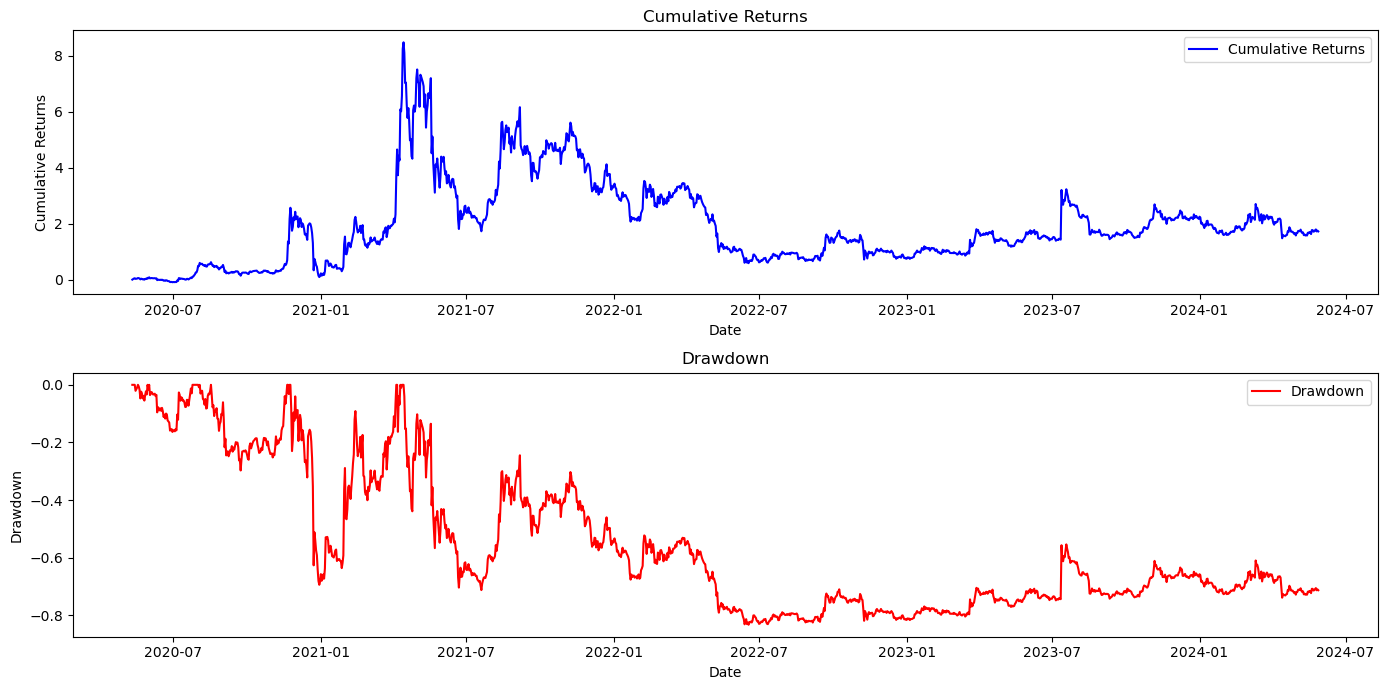

Maximum Drawdown: -83.25%


In [21]:
# Assuming df is your dataframe and 'XRP' is the column with daily closing prices
prices = df['XRP']

# Calculate cumulative returns
cumulative_returns = (prices / prices.iloc[0]) - 1

# Calculate running maximum
running_max = np.maximum.accumulate(prices)
running_max[running_max < 0] = 0

# Calculate drawdowns
drawdown = (prices - running_max) / running_max

# Calculate max drawdown
max_drawdown = drawdown.min()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

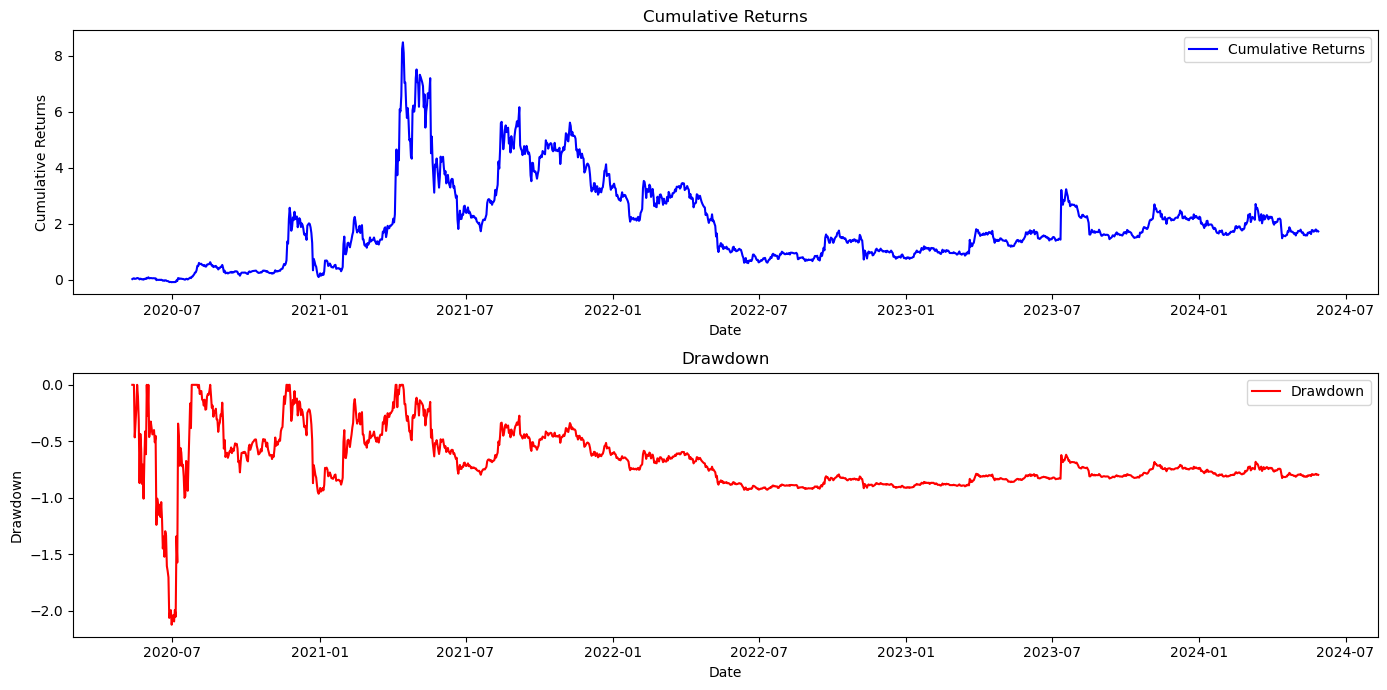

Maximum Drawdown: -212.41%


In [22]:
# Assuming returns is your dataframe with daily returns and 'XRP' is the column with daily returns
returns_xrp = returns['XRP']

# Calculate cumulative returns
cumulative_returns = (1 + returns_xrp).cumprod() - 1

# Calculate running maximum
running_max = np.maximum.accumulate(cumulative_returns)
running_max[running_max < 0] = 0

# Calculate drawdowns
drawdown = (cumulative_returns - running_max) / running_max

# Calculate max drawdown
max_drawdown = drawdown.min()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

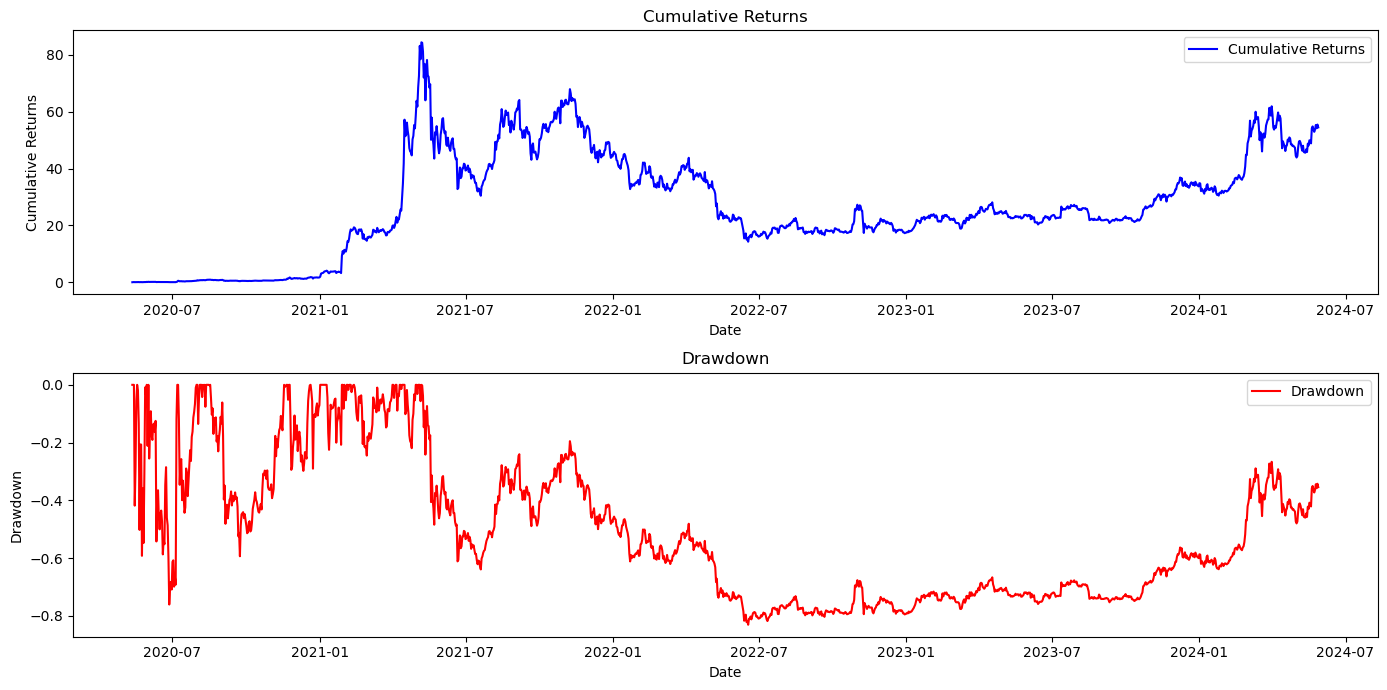

Maximum Drawdown: -83.10%


In [23]:
# Extract weights from the dataframe 'w'
weights = w.iloc[:, 0]

# Calculate the portfolio returns
portfolio_returns = (returns * weights).sum(axis=1)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# Calculate running maximum
running_max = np.maximum.accumulate(cumulative_returns)
running_max[running_max < 0] = 0

# Calculate drawdowns
drawdown = (cumulative_returns - running_max) / running_max

# Calculate max drawdown
max_drawdown = drawdown.min()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

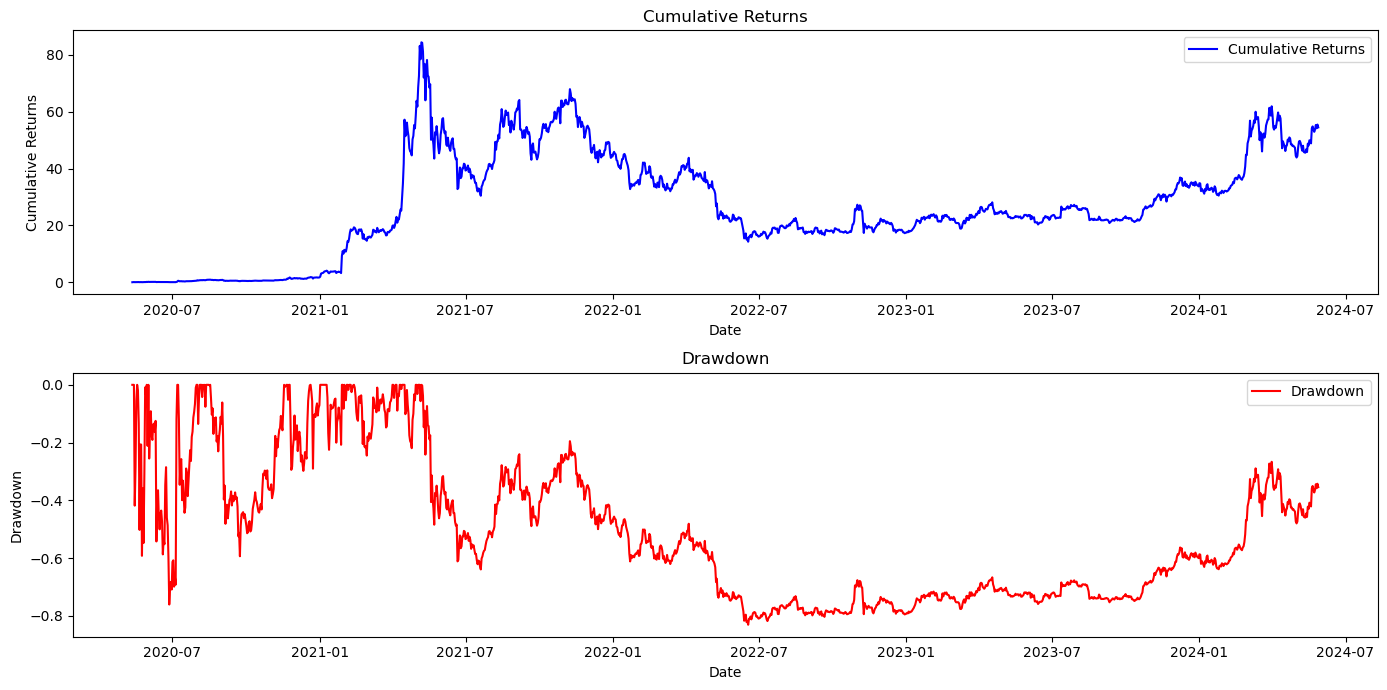

Maximum Drawdown: -83.10%


In [24]:
# Extract weights from the dataframe 'w'
weights = w.iloc[:, 0]

# Calculate daily returns from daily closing prices
returns = df.pct_change().dropna()

# Calculate the portfolio returns
portfolio_returns = (returns * weights).sum(axis=1)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# Calculate running maximum
running_max = np.maximum.accumulate(cumulative_returns)
running_max[running_max < 0] = 0

# Calculate drawdowns
drawdown = (cumulative_returns - running_max) / running_max

# Calculate max drawdown
max_drawdown = drawdown.min()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Maximum Drawdown: {max_drawdown:.2%}")